In [1]:
import os
images = []
for dirs, subdirs, files in os.walk('Phoenix1'):
    images.append(files)

images[0][:5]

['20140911_1315.jpg',
 '20140325_1020.jpg',
 '20141103_1640.jpg',
 '20140613_1445.jpg',
 '20140322_1620.jpg']

In [2]:
flattened_images_list = [image for images_item in images for image in images_item]
flattened_images_list[:5]

['20140911_1315.jpg',
 '20140325_1020.jpg',
 '20141103_1640.jpg',
 '20140613_1445.jpg',
 '20140322_1620.jpg']

In [3]:
len(flattened_images_list)

4303

In [4]:
import pandas as pd 
df = pd.read_csv("pm2.csv")

In [5]:
df.head()

,date,pm2.5
0,20140101,73
1,20140102,86
2,20140103,59
3,20140104,83
4,20140105,79


In [6]:
from struct import unpack
import os


marker_mapping = {
    0xffd8: "Start of Image",
    0xffe0: "Application Default Header",
    0xffdb: "Quantization Table",
    0xffc0: "Start of Frame",
    0xffc4: "Define Huffman Table",
    0xffda: "Start of Scan",
    0xffd9: "End of Image"
}


class JPEG:
    def __init__(self, image_file):
        with open(image_file, 'rb') as f:
            self.img_data = f.read()
    
    def decode(self):
        data = self.img_data
        while(True):
            marker, = unpack(">H", data[0:2])
            # print(marker_mapping.get(marker))
            if marker == 0xffd8:
                data = data[2:]
            elif marker == 0xffd9:
                return
            elif marker == 0xffda:
                data = data[-2:]
            else:
                lenchunk, = unpack(">H", data[2:4])
                data = data[2+lenchunk:]            
            if len(data)==0:
                break        


bads = []
root_img = 'Phoenix1/'
for img in flattened_images_list:
    image = os.path.join(root_img,img)
    image = JPEG(image) 
    try:
        image.decode()   

    except:
        bads.append(img)

for name in bads:
    print(name)
    os.remove(os.path.join(root_img,name))

In [7]:
images = []
for dirs, subdirs, files in os.walk('Phoenix1'):
    images.append(files)

images[0][:5]

['20140911_1315.jpg',
 '20140325_1020.jpg',
 '20141103_1640.jpg',
 '20140613_1445.jpg',
 '20140322_1620.jpg']

In [8]:
flattened_images_list = [image for images_item in images for image in images_item]
flattened_images_list[:5]

['20140911_1315.jpg',
 '20140325_1020.jpg',
 '20141103_1640.jpg',
 '20140613_1445.jpg',
 '20140322_1620.jpg']

In [9]:
len(flattened_images_list)

4303

In [10]:
import shutil
def copyfile(filename,destination):
    shutil.copyfile(filename,destination)

for image in flattened_images_list:
    date = image[:8]
    index_val = df[df['date'] == int(date)].index.values[0]
    pm_val = df['pm2.5'][index_val]
    print(pm_val)
    if pm_val > 54:
        filename = 'Phoenix1/'+image
        destination = 'dataset/danger/'+image
        copyfile(filename,destination)
        continue
    elif pm_val < 30:
        filename = 'Phoenix1/'+image
        destination = 'dataset/healthy/'+image
        copyfile(filename,destination)
        continue
    else:
        filename = 'Phoenix1/'+image
        destination = 'dataset/moderate/'+image
        copyfile(filename,destination)


In [11]:
class_names = []
for dirs, subdirs,files in os.walk('dataset'):
    class_names.append(subdirs)
class_names = [item for sublist in class_names for item in sublist]
class_names

['healthy', 'danger', 'moderate']

In [12]:
for dir in os.listdir('dataset'):
    print(dir)
    print(len(os.listdir('dataset/'+dir)))

healthy
2232
danger
2232
moderate
2232


In [13]:
import tensorflow as tf 

In [14]:
import habana_frameworks.tensorflow as htf
htf.load_habana_module()

In [15]:
import ipyparallel as ipp
import os
os.environ["OMPI_ALLOW_RUN_AS_ROOT"] = "1"
os.environ["OMPI_ALLOW_RUN_AS_ROOT_CONFIRM"] = "1"

n_hpu=8
cluster = ipp.Cluster(engines='mpi', n=n_hpu)
client = cluster.start_and_connect_sync()

Starting 8 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/8 [00:00<?, ?engine/s]

In [16]:
%%px
import tensorflow as tf


In [17]:
%%px
batch_size = 16
img_height = 180
img_width = 180
data_dir = 'dataset/'

In [18]:
%%px
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = 'training',
    seed = 42,
    image_size = (img_height,img_width),
    batch_size=batch_size
)

[stdout:4] Found 6696 files belonging to 3 classes.
Using 5357 files for training.


[stdout:0] Found 6696 files belonging to 3 classes.
Using 5357 files for training.


[stdout:6] Found 6696 files belonging to 3 classes.
Using 5357 files for training.


[stderr:4] 2022-02-26 16:01:56.174040: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[stdout:1] Found 6696 files belonging to 3 classes.
Using 5357 files for training.


[stderr:0] 2022-02-26 16:01:56.174040: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[stderr:6] 2022-02-26 16:01:56.173999: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[stderr:1] 2022-02-26 16:01:56.174832: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[stdout:2] Found 6696 files belonging to 3 classes.
Using 5357 files for training.


[stderr:2] 2022-02-26 16:01:56.177992: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[stdout:5] Found 6696 files belonging to 3 classes.
Using 5357 files for training.


[stderr:5] 2022-02-26 16:01:56.179062: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[stdout:7] Found 6696 files belonging to 3 classes.
Using 5357 files for training.


[stderr:7] 2022-02-26 16:01:56.187989: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[stdout:3] Found 6696 files belonging to 3 classes.
Using 5357 files for training.


[stderr:3] 2022-02-26 16:01:56.195138: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
%%px
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = 'validation',
    seed = 42,
    image_size = (img_height,img_width),
    batch_size=batch_size
)

[stdout:1] Found 6696 files belonging to 3 classes.
Using 1339 files for validation.


[stdout:3] Found 6696 files belonging to 3 classes.
Using 1339 files for validation.


[stdout:0] Found 6696 files belonging to 3 classes.
Using 1339 files for validation.


[stdout:4] Found 6696 files belonging to 3 classes.
Using 1339 files for validation.


[stdout:5] Found 6696 files belonging to 3 classes.
Using 1339 files for validation.


[stdout:2] Found 6696 files belonging to 3 classes.
Using 1339 files for validation.


[stdout:6] Found 6696 files belonging to 3 classes.
Using 1339 files for validation.


[stdout:7] Found 6696 files belonging to 3 classes.
Using 1339 files for validation.


In [20]:
%%px
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [21]:
%%px
base_model = tf.keras.applications.efficientnet.EfficientNetB0(
    include_top=False, weights='imagenet',
)

In [22]:
%%px
base_model.trainable = False
for layer in base_model.layers[-100:]:
    layer.trainable = True

In [23]:
%%px
#create model

top = tf.keras.layers.Input(shape=(img_height,img_width,3))
x = base_model(top)
x = tf.keras.layers.GlobalMaxPooling2D()(x)
bottom = tf.keras.layers.Dense(3,activation='softmax')(x)

model_1 = tf.keras.Model(top,bottom)

In [24]:
%%px
model_1.summary()

[stdout:6] Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_max_pooling2d (Globa  (None, 1280)             0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 4,053,414
Trainable params: 3,843
Non-trainable params: 4,049,571
_________________________________________________________________


[stdout:1] Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_max_pooling2d (Globa  (None, 1280)             0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 4,053,414
Trainable params: 3,843
Non-trainable params: 4,049,571
_________________________________________________________________


[stdout:0] Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_max_pooling2d (Globa  (None, 1280)             0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 4,053,414
Trainable params: 3,843
Non-trainable params: 4,049,571
_________________________________________________________________


[stdout:7] Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_max_pooling2d (Globa  (None, 1280)             0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 4,053,414
Trainable params: 3,843
Non-trainable params: 4,049,571
_________________________________________________________________


[stdout:5] Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_max_pooling2d (Globa  (None, 1280)             0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 4,053,414
Trainable params: 3,843
Non-trainable params: 4,049,571
_________________________________________________________________


[stdout:2] Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_max_pooling2d (Globa  (None, 1280)             0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 4,053,414
Trainable params: 3,843
Non-trainable params: 4,049,571
_________________________________________________________________


[stdout:3] Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_max_pooling2d (Globa  (None, 1280)             0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 4,053,414
Trainable params: 3,843
Non-trainable params: 4,049,571
_________________________________________________________________


[stdout:4] Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_max_pooling2d (Globa  (None, 1280)             0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 4,053,414
Trainable params: 3,843
Non-trainable params: 4,049,571
_________________________________________________________________


In [25]:
%%px
#compile model

model_1.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [26]:
%%px

from mpi4py import MPI

BASE_TF_SERVER_PORT = 7850
SHUFFLE_BUFFER_SIZE = 10000

num_workers = MPI.COMM_WORLD.Get_size()
worker_index = MPI.COMM_WORLD.Get_rank()

def set_tf_config():
    """ Makes a TensorFlow cluster information and sets it to TF_CONFIG environment variable.
    """
    tf_config = {
        "cluster": {
            "worker": [f"localhost:{BASE_TF_SERVER_PORT + index}" for index in range(num_workers)]
        },
        "task": {"type": "worker", "index": worker_index}
    }
    tf_config_text = json.dumps(tf_config)
    os.environ["TF_CONFIG"] = tf_config_text
    print(f"TF_CONFIG = {tf_config_text}")
    return tf_config_text

In [27]:
%%px
early_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    verbose=0,
    mode="auto",
    restore_best_weights=True,
)

# Training with one gaudi core accelerator

In [28]:
%%px

history_1 = model_1.fit(
    train_ds,
    validation_data = val_ds,
    epochs=200,
    callbacks=[early_callback]
)

[stdout:2] Epoch 1/200
335/335 [==============================] - 68s 192ms/step - loss: 1.5051 - accuracy: 0.5387 - val_loss: 0.9754 - val_accuracy: 0.6117
Epoch 2/200
335/335 [==============================] - 60s 178ms/step - loss: 1.1196 - accuracy: 0.6171 - val_loss: 0.7953 - val_accuracy: 0.6669
Epoch 3/200
335/335 [==============================] - 54s 160ms/step - loss: 1.0284 - accuracy: 0.6371 - val_loss: 0.7519 - val_accuracy: 0.6990
Epoch 4/200
335/335 [==============================] - 51s 152ms/step - loss: 0.9506 - accuracy: 0.6535 - val_loss: 0.8434 - val_accuracy: 0.6617
Epoch 5/200
335/335 [==============================] - 49s 147ms/step - loss: 0.9229 - accuracy: 0.6604 - val_loss: 0.6980 - val_accuracy: 0.7005
Epoch 6/200
335/335 [==============================] - 56s 168ms/step - loss: 0.8756 - accuracy: 0.6730 - val_loss: 0.6858 - val_accuracy: 0.7043
Epoch 7/200
335/335 [==============================] - 56s 168ms/step - loss: 0.8649 - accuracy: 0.6756 - val_los

[stdout:1] Epoch 1/200
335/335 [==============================] - 68s 191ms/step - loss: 1.5840 - accuracy: 0.5397 - val_loss: 1.0002 - val_accuracy: 0.6243
Epoch 2/200
335/335 [==============================] - 59s 175ms/step - loss: 1.1855 - accuracy: 0.6110 - val_loss: 0.8513 - val_accuracy: 0.7043
Epoch 3/200
335/335 [==============================] - 59s 175ms/step - loss: 1.0276 - accuracy: 0.6321 - val_loss: 0.7533 - val_accuracy: 0.7184
Epoch 4/200
335/335 [==============================] - 59s 176ms/step - loss: 1.0104 - accuracy: 0.6425 - val_loss: 0.7314 - val_accuracy: 0.7304
Epoch 5/200
335/335 [==============================] - 43s 128ms/step - loss: 0.9710 - accuracy: 0.6575 - val_loss: 0.7390 - val_accuracy: 0.7341
Epoch 6/200
335/335 [==============================] - 46s 138ms/step - loss: 0.8463 - accuracy: 0.6746 - val_loss: 0.6707 - val_accuracy: 0.7446
Epoch 7/200
335/335 [==============================] - 56s 167ms/step - loss: 0.8524 - accuracy: 0.6784 - val_los

[stdout:3] Epoch 1/200
335/335 [==============================] - 68s 193ms/step - loss: 1.4759 - accuracy: 0.5602 - val_loss: 0.8957 - val_accuracy: 0.6580
Epoch 2/200
335/335 [==============================] - 60s 178ms/step - loss: 1.1484 - accuracy: 0.6199 - val_loss: 0.7944 - val_accuracy: 0.6916
Epoch 3/200
335/335 [==============================] - 58s 174ms/step - loss: 1.0289 - accuracy: 0.6451 - val_loss: 0.7080 - val_accuracy: 0.7072
Epoch 4/200
335/335 [==============================] - 58s 173ms/step - loss: 1.0007 - accuracy: 0.6431 - val_loss: 0.6915 - val_accuracy: 0.7334
Epoch 5/200
335/335 [==============================] - 42s 126ms/step - loss: 0.8990 - accuracy: 0.6662 - val_loss: 0.7006 - val_accuracy: 0.7274
Epoch 6/200
335/335 [==============================] - 57s 170ms/step - loss: 0.9222 - accuracy: 0.6664 - val_loss: 0.6632 - val_accuracy: 0.7229
Epoch 7/200
335/335 [==============================] - 57s 170ms/step - loss: 0.8439 - accuracy: 0.6894 - val_los

[stdout:6] Epoch 1/200
335/335 [==============================] - 67s 189ms/step - loss: 1.4977 - accuracy: 0.5449 - val_loss: 0.8490 - val_accuracy: 0.6744
Epoch 2/200
335/335 [==============================] - 59s 175ms/step - loss: 1.1440 - accuracy: 0.6138 - val_loss: 0.7404 - val_accuracy: 0.7013
Epoch 3/200
335/335 [==============================] - 59s 175ms/step - loss: 1.0068 - accuracy: 0.6328 - val_loss: 0.7126 - val_accuracy: 0.7184
Epoch 4/200
335/335 [==============================] - 50s 150ms/step - loss: 0.9529 - accuracy: 0.6470 - val_loss: 0.7116 - val_accuracy: 0.7080
Epoch 5/200
335/335 [==============================] - 59s 177ms/step - loss: 0.9221 - accuracy: 0.6586 - val_loss: 0.7680 - val_accuracy: 0.6819
Epoch 6/200
335/335 [==============================] - 60s 179ms/step - loss: 0.8409 - accuracy: 0.6864 - val_loss: 0.6330 - val_accuracy: 0.7371
Epoch 7/200
335/335 [==============================] - 58s 174ms/step - loss: 0.8560 - accuracy: 0.6795 - val_los

[stdout:5] Epoch 1/200
335/335 [==============================] - 68s 191ms/step - loss: 1.5489 - accuracy: 0.5371 - val_loss: 0.8852 - val_accuracy: 0.6460
Epoch 2/200
335/335 [==============================] - 60s 178ms/step - loss: 1.1430 - accuracy: 0.6151 - val_loss: 0.7342 - val_accuracy: 0.6953
Epoch 3/200
335/335 [==============================] - 58s 174ms/step - loss: 1.0220 - accuracy: 0.6360 - val_loss: 0.7607 - val_accuracy: 0.7147
Epoch 4/200
335/335 [==============================] - 42s 124ms/step - loss: 0.9781 - accuracy: 0.6483 - val_loss: 0.6883 - val_accuracy: 0.7304
Epoch 5/200
335/335 [==============================] - 57s 169ms/step - loss: 0.9211 - accuracy: 0.6584 - val_loss: 0.7143 - val_accuracy: 0.7125
Epoch 6/200
335/335 [==============================] - 44s 132ms/step - loss: 0.8698 - accuracy: 0.6791 - val_loss: 0.6502 - val_accuracy: 0.7453
Epoch 7/200
335/335 [==============================] - 56s 168ms/step - loss: 0.8583 - accuracy: 0.6778 - val_los

[stdout:4] Epoch 1/200
335/335 [==============================] - 68s 191ms/step - loss: 1.5100 - accuracy: 0.5505 - val_loss: 0.8584 - val_accuracy: 0.6632
Epoch 2/200
335/335 [==============================] - 59s 177ms/step - loss: 1.1442 - accuracy: 0.6106 - val_loss: 0.7594 - val_accuracy: 0.7132
Epoch 3/200
335/335 [==============================] - 53s 157ms/step - loss: 0.9951 - accuracy: 0.6418 - val_loss: 0.7084 - val_accuracy: 0.7199
Epoch 4/200
335/335 [==============================] - 52s 157ms/step - loss: 0.9126 - accuracy: 0.6631 - val_loss: 0.6485 - val_accuracy: 0.7252
Epoch 5/200
335/335 [==============================] - 51s 152ms/step - loss: 0.8620 - accuracy: 0.6758 - val_loss: 0.6319 - val_accuracy: 0.7498
Epoch 6/200
335/335 [==============================] - 58s 172ms/step - loss: 0.8826 - accuracy: 0.6759 - val_loss: 0.6355 - val_accuracy: 0.7304
Epoch 7/200
335/335 [==============================] - 58s 172ms/step - loss: 0.8415 - accuracy: 0.6797 - val_los

[stdout:7] Epoch 1/200
335/335 [==============================] - 69s 194ms/step - loss: 1.5087 - accuracy: 0.5512 - val_loss: 0.9749 - val_accuracy: 0.6191
Epoch 2/200
335/335 [==============================] - 60s 180ms/step - loss: 1.1564 - accuracy: 0.6104 - val_loss: 1.0741 - val_accuracy: 0.5907
Epoch 3/200
335/335 [==============================] - 59s 175ms/step - loss: 1.0430 - accuracy: 0.6388 - val_loss: 0.7465 - val_accuracy: 0.7020
Epoch 4/200
335/335 [==============================] - 46s 136ms/step - loss: 0.9350 - accuracy: 0.6552 - val_loss: 0.7718 - val_accuracy: 0.6893
Epoch 5/200
335/335 [==============================] - 58s 175ms/step - loss: 0.9304 - accuracy: 0.6616 - val_loss: 0.8013 - val_accuracy: 0.6580
Epoch 6/200
335/335 [==============================] - 50s 151ms/step - loss: 0.8654 - accuracy: 0.6739 - val_loss: 0.7075 - val_accuracy: 0.6908
Epoch 7/200
335/335 [==============================] - 56s 167ms/step - loss: 0.8181 - accuracy: 0.6922 - val_los

[stdout:0] Epoch 1/200
335/335 [==============================] - 69s 193ms/step - loss: 1.5540 - accuracy: 0.5466 - val_loss: 0.8537 - val_accuracy: 0.6662
Epoch 2/200
335/335 [==============================] - 60s 179ms/step - loss: 1.1400 - accuracy: 0.6216 - val_loss: 0.7088 - val_accuracy: 0.7028
Epoch 3/200
335/335 [==============================] - 56s 166ms/step - loss: 1.0201 - accuracy: 0.6354 - val_loss: 0.7147 - val_accuracy: 0.6893
Epoch 4/200
335/335 [==============================] - 54s 161ms/step - loss: 0.9862 - accuracy: 0.6481 - val_loss: 0.7892 - val_accuracy: 0.6848
Epoch 5/200
335/335 [==============================] - 60s 178ms/step - loss: 0.8997 - accuracy: 0.6705 - val_loss: 0.6237 - val_accuracy: 0.7289
Epoch 6/200
335/335 [==============================] - 59s 176ms/step - loss: 0.9018 - accuracy: 0.6718 - val_loss: 0.6408 - val_accuracy: 0.7356
Epoch 7/200
335/335 [==============================] - 59s 177ms/step - loss: 0.8462 - accuracy: 0.6806 - val_los

%px:   0%|          | 0/8 [00:00<?, ?tasks/s]

In [29]:
%%px
model_1.evaluate(val_ds)

[stdout:6] 84/84 [==============================] - 10s 125ms/step - loss: 0.5666 - accuracy: 0.7722


[stdout:3] 84/84 [==============================] - 11s 125ms/step - loss: 0.5975 - accuracy: 0.7461


[stdout:0] 84/84 [==============================] - 11s 130ms/step - loss: 0.5778 - accuracy: 0.7625


[stdout:5] 84/84 [==============================] - 11s 129ms/step - loss: 0.6164 - accuracy: 0.7491


[stdout:1] 84/84 [==============================] - 11s 126ms/step - loss: 0.5804 - accuracy: 0.7685


[stdout:7] 84/84 [==============================] - 11s 129ms/step - loss: 0.6215 - accuracy: 0.7416


[stdout:4] 84/84 [==============================] - 11s 128ms/step - loss: 0.6319 - accuracy: 0.7498


[stdout:2] 84/84 [==============================] - 11s 127ms/step - loss: 0.6034 - accuracy: 0.7468


%px:   0%|          | 0/8 [00:00<?, ?tasks/s]

Out[6:14]: [0.5666400790214539, 0.7722180485725403]

Out[1:14]: [0.5803775191307068, 0.7684839367866516]

Out[2:14]: [0.6034286618232727, 0.7468259930610657]

Out[4:14]: [0.6319094300270081, 0.7498133182525635]

Out[5:14]: [0.6164113879203796, 0.7490664720535278]

Out[7:14]: [0.6215060353279114, 0.7415981888771057]

Out[0:14]: [0.577778697013855, 0.7625093460083008]

Out[3:14]: [0.597486674785614, 0.74607914686203]

# Using multiple cores gaudi accelerators

In [34]:
%%px
import os
import json 
def train_model():
    set_tf_config()
    options = tf.data.Options()
    options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
    options = tf.data.Options()
    options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF
    # Create and compile the distributed CNN model.
    model_1 = tf.keras.Model(top,bottom)
    model_1.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
        
    # Train the model.
    print("Calling model.fit()...")
    history_1 = model_1.fit(
    train_ds,
    validation_data = val_ds,
    epochs=200,
    callbacks=[early_callback]
)
    print("Calling model.evaluate()...")
    eval_results = model_1.evaluate(val_ds, verbose=2)
    print(f"Evaluation results: {eval_results}")

In [35]:
%%px
train_model()

[stdout:0] TF_CONFIG = {"cluster": {"worker": ["localhost:7850", "localhost:7851", "localhost:7852", "localhost:7853", "localhost:7854", "localhost:7855", "localhost:7856", "localhost:7857"]}, "task": {"type": "worker", "index": 0}}
Calling model.fit()...
Epoch 1/200
335/335 [==============================] - 63s 179ms/step - loss: 0.8135 - accuracy: 0.6892 - val_loss: 0.5961 - val_accuracy: 0.7670
Epoch 2/200
335/335 [==============================] - 59s 175ms/step - loss: 0.7740 - accuracy: 0.7051 - val_loss: 0.5761 - val_accuracy: 0.7767
Epoch 3/200
335/335 [==============================] - 53s 158ms/step - loss: 0.7503 - accuracy: 0.7088 - val_loss: 0.5962 - val_accuracy: 0.7692
Epoch 4/200
335/335 [==============================] - 58s 174ms/step - loss: 0.8147 - accuracy: 0.6954 - val_loss: 0.7154 - val_accuracy: 0.7028
Epoch 5/200
335/335 [==============================] - 59s 175ms/step - loss: 0.7790 - accuracy: 0.7002 - val_loss: 0.5636 - val_accuracy: 0.7550
Epoch 6/200
33

[stdout:7] TF_CONFIG = {"cluster": {"worker": ["localhost:7850", "localhost:7851", "localhost:7852", "localhost:7853", "localhost:7854", "localhost:7855", "localhost:7856", "localhost:7857"]}, "task": {"type": "worker", "index": 7}}
Calling model.fit()...
Epoch 1/200
335/335 [==============================] - 63s 178ms/step - loss: 0.8118 - accuracy: 0.6952 - val_loss: 0.5839 - val_accuracy: 0.7528
Epoch 2/200
335/335 [==============================] - 57s 170ms/step - loss: 0.7909 - accuracy: 0.6935 - val_loss: 0.6440 - val_accuracy: 0.7461
Epoch 3/200
335/335 [==============================] - 49s 146ms/step - loss: 0.8049 - accuracy: 0.6954 - val_loss: 0.6028 - val_accuracy: 0.7655
Epoch 4/200
335/335 [==============================] - 49s 146ms/step - loss: 0.7956 - accuracy: 0.7011 - val_loss: 0.6228 - val_accuracy: 0.7498
Calling model.evaluate()...
84/84 - 8s - loss: 0.5839 - accuracy: 0.7528 - 8s/epoch - 91ms/step
Evaluation results: [0.5839441418647766, 0.7528005838394165]


[stdout:1] TF_CONFIG = {"cluster": {"worker": ["localhost:7850", "localhost:7851", "localhost:7852", "localhost:7853", "localhost:7854", "localhost:7855", "localhost:7856", "localhost:7857"]}, "task": {"type": "worker", "index": 1}}
Calling model.fit()...
Epoch 1/200
335/335 [==============================] - 63s 177ms/step - loss: 0.7802 - accuracy: 0.7116 - val_loss: 0.6339 - val_accuracy: 0.7446
Epoch 2/200
335/335 [==============================] - 57s 171ms/step - loss: 0.7514 - accuracy: 0.7129 - val_loss: 0.7169 - val_accuracy: 0.7102
Epoch 3/200
335/335 [==============================] - 41s 123ms/step - loss: 0.7797 - accuracy: 0.7069 - val_loss: 0.5482 - val_accuracy: 0.7872
Epoch 4/200
335/335 [==============================] - 48s 142ms/step - loss: 0.7577 - accuracy: 0.7073 - val_loss: 0.5935 - val_accuracy: 0.7707
Epoch 5/200
335/335 [==============================] - 24s 73ms/step - loss: 0.7658 - accuracy: 0.7071 - val_loss: 0.5993 - val_accuracy: 0.7506
Epoch 6/200
335

[stdout:3] TF_CONFIG = {"cluster": {"worker": ["localhost:7850", "localhost:7851", "localhost:7852", "localhost:7853", "localhost:7854", "localhost:7855", "localhost:7856", "localhost:7857"]}, "task": {"type": "worker", "index": 3}}
Calling model.fit()...
Epoch 1/200
335/335 [==============================] - 61s 173ms/step - loss: 0.7571 - accuracy: 0.7062 - val_loss: 0.5660 - val_accuracy: 0.7737
Epoch 2/200
335/335 [==============================] - 57s 171ms/step - loss: 0.7585 - accuracy: 0.7086 - val_loss: 0.6285 - val_accuracy: 0.7565
Epoch 3/200
335/335 [==============================] - 49s 146ms/step - loss: 0.7496 - accuracy: 0.7122 - val_loss: 0.5990 - val_accuracy: 0.7760
Epoch 4/200
335/335 [==============================] - 48s 144ms/step - loss: 0.7670 - accuracy: 0.7084 - val_loss: 0.6468 - val_accuracy: 0.7535
Calling model.evaluate()...
84/84 - 8s - loss: 0.5660 - accuracy: 0.7737 - 8s/epoch - 98ms/step
Evaluation results: [0.5660067796707153, 0.7737117409706116]


[stdout:6] TF_CONFIG = {"cluster": {"worker": ["localhost:7850", "localhost:7851", "localhost:7852", "localhost:7853", "localhost:7854", "localhost:7855", "localhost:7856", "localhost:7857"]}, "task": {"type": "worker", "index": 6}}
Calling model.fit()...
Epoch 1/200
335/335 [==============================] - 62s 175ms/step - loss: 0.8120 - accuracy: 0.6840 - val_loss: 0.7136 - val_accuracy: 0.7028
Epoch 2/200
335/335 [==============================] - 58s 173ms/step - loss: 0.8114 - accuracy: 0.6940 - val_loss: 0.5857 - val_accuracy: 0.7715
Epoch 3/200
335/335 [==============================] - 58s 172ms/step - loss: 0.7715 - accuracy: 0.7032 - val_loss: 0.6263 - val_accuracy: 0.7341
Epoch 4/200
335/335 [==============================] - 57s 171ms/step - loss: 0.7804 - accuracy: 0.7049 - val_loss: 0.6336 - val_accuracy: 0.7423
Epoch 5/200
335/335 [==============================] - 54s 163ms/step - loss: 0.7096 - accuracy: 0.7176 - val_loss: 0.5653 - val_accuracy: 0.7677
Epoch 6/200
33

[stdout:2] TF_CONFIG = {"cluster": {"worker": ["localhost:7850", "localhost:7851", "localhost:7852", "localhost:7853", "localhost:7854", "localhost:7855", "localhost:7856", "localhost:7857"]}, "task": {"type": "worker", "index": 2}}
Calling model.fit()...
Epoch 1/200
335/335 [==============================] - 61s 172ms/step - loss: 0.8165 - accuracy: 0.6959 - val_loss: 0.5917 - val_accuracy: 0.7662
Epoch 2/200
335/335 [==============================] - 57s 171ms/step - loss: 0.7626 - accuracy: 0.7105 - val_loss: 0.6237 - val_accuracy: 0.7543
Epoch 3/200
335/335 [==============================] - 50s 150ms/step - loss: 0.7599 - accuracy: 0.7073 - val_loss: 0.5738 - val_accuracy: 0.7618
Epoch 4/200
335/335 [==============================] - 58s 172ms/step - loss: 0.7790 - accuracy: 0.7024 - val_loss: 0.5675 - val_accuracy: 0.7625
Epoch 5/200
335/335 [==============================] - 57s 170ms/step - loss: 0.7760 - accuracy: 0.7086 - val_loss: 0.6304 - val_accuracy: 0.7647
Epoch 6/200
33

[stdout:4] TF_CONFIG = {"cluster": {"worker": ["localhost:7850", "localhost:7851", "localhost:7852", "localhost:7853", "localhost:7854", "localhost:7855", "localhost:7856", "localhost:7857"]}, "task": {"type": "worker", "index": 4}}
Calling model.fit()...
Epoch 1/200
335/335 [==============================] - 64s 180ms/step - loss: 0.7970 - accuracy: 0.6991 - val_loss: 0.5801 - val_accuracy: 0.7707
Epoch 2/200
335/335 [==============================] - 58s 173ms/step - loss: 0.7657 - accuracy: 0.6965 - val_loss: 0.5575 - val_accuracy: 0.7677
Epoch 3/200
335/335 [==============================] - 53s 157ms/step - loss: 0.7977 - accuracy: 0.7032 - val_loss: 0.5677 - val_accuracy: 0.7535
Epoch 4/200
335/335 [==============================] - 59s 176ms/step - loss: 0.7462 - accuracy: 0.7112 - val_loss: 0.5702 - val_accuracy: 0.7722
Epoch 5/200
335/335 [==============================] - 58s 173ms/step - loss: 0.7951 - accuracy: 0.7017 - val_loss: 0.5894 - val_accuracy: 0.7573
Calling model.

[stdout:5] TF_CONFIG = {"cluster": {"worker": ["localhost:7850", "localhost:7851", "localhost:7852", "localhost:7853", "localhost:7854", "localhost:7855", "localhost:7856", "localhost:7857"]}, "task": {"type": "worker", "index": 5}}
Calling model.fit()...
Epoch 1/200
335/335 [==============================] - 61s 172ms/step - loss: 0.7852 - accuracy: 0.7060 - val_loss: 0.5806 - val_accuracy: 0.7640
Epoch 2/200
335/335 [==============================] - 57s 171ms/step - loss: 0.7678 - accuracy: 0.7079 - val_loss: 0.6229 - val_accuracy: 0.7521
Epoch 3/200
335/335 [==============================] - 40s 119ms/step - loss: 0.7772 - accuracy: 0.6993 - val_loss: 0.7239 - val_accuracy: 0.7043
Epoch 4/200
335/335 [==============================] - 46s 137ms/step - loss: 0.7482 - accuracy: 0.7131 - val_loss: 0.6360 - val_accuracy: 0.7468
Calling model.evaluate()...
84/84 - 10s - loss: 0.5806 - accuracy: 0.7640 - 10s/epoch - 124ms/step
Evaluation results: [0.5805648565292358, 0.7640029788017273]


%px:   0%|          | 0/8 [00:00<?, ?tasks/s]

In [36]:
%%px
eval_results = model_1.evaluate(val_ds, verbose=2)

%px:   0%|          | 0/8 [00:00<?, ?tasks/s]

[stdout:6] 84/84 - 10s - loss: 0.5653 - accuracy: 0.7677 - 10s/epoch - 123ms/step


[stdout:0] 84/84 - 10s - loss: 0.5486 - accuracy: 0.7603 - 10s/epoch - 124ms/step


[stdout:5] 84/84 - 11s - loss: 0.5806 - accuracy: 0.7640 - 11s/epoch - 125ms/step


[stdout:3] 84/84 - 11s - loss: 0.5660 - accuracy: 0.7737 - 11s/epoch - 125ms/step


[stdout:7] 84/84 - 11s - loss: 0.5839 - accuracy: 0.7528 - 11s/epoch - 126ms/step


[stdout:1] 84/84 - 11s - loss: 0.5482 - accuracy: 0.7872 - 11s/epoch - 127ms/step


[stdout:2] 84/84 - 11s - loss: 0.5557 - accuracy: 0.7700 - 11s/epoch - 127ms/step


[stdout:4] 84/84 - 11s - loss: 0.5575 - accuracy: 0.7677 - 11s/epoch - 127ms/step


In [37]:
%%px
model_1.save("model1")

%px:   0%|          | 0/8 [00:00<?, ?tasks/s]

[stderr:2] 2022-02-26 16:34:33.418189: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/home/ubuntu/.local/lib/python3.7/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/ubuntu/.local/lib/python3.7/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


[stderr:3] 2022-02-26 16:34:33.458913: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/home/ubuntu/.local/lib/python3.7/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/ubuntu/.local/lib/python3.7/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


[stderr:7] 2022-02-26 16:34:33.548794: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/home/ubuntu/.local/lib/python3.7/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/ubuntu/.local/lib/python3.7/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


[stderr:4] 2022-02-26 16:34:33.587985: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/home/ubuntu/.local/lib/python3.7/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/ubuntu/.local/lib/python3.7/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


[stderr:0] 2022-02-26 16:34:33.584328: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/home/ubuntu/.local/lib/python3.7/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/ubuntu/.local/lib/python3.7/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


[stderr:6] 2022-02-26 16:34:33.593772: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/home/ubuntu/.local/lib/python3.7/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/ubuntu/.local/lib/python3.7/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


[stderr:5] 2022-02-26 16:34:33.605380: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/home/ubuntu/.local/lib/python3.7/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/ubuntu/.local/lib/python3.7/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


[stderr:1] 2022-02-26 16:34:34.130527: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/home/ubuntu/.local/lib/python3.7/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/ubuntu/.local/lib/python3.7/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Out[6:23]: [<matplotlib.lines.Line2D at 0x7f6d0852cbd0>]

Out[1:23]: [<matplotlib.lines.Line2D at 0x7efde00b4f90>]

Out[3:23]: [<matplotlib.lines.Line2D at 0x7f1e538df890>]

[output:6]

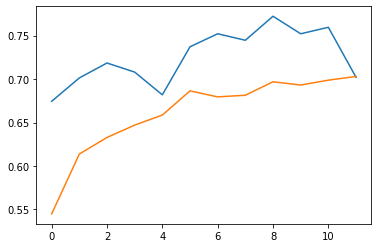

Out[4:23]: [<matplotlib.lines.Line2D at 0x7f95a02dd510>]

%px:   0%|          | 0/8 [00:00<?, ?tasks/s]

[output:3]

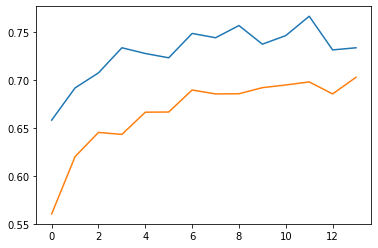

[output:1]

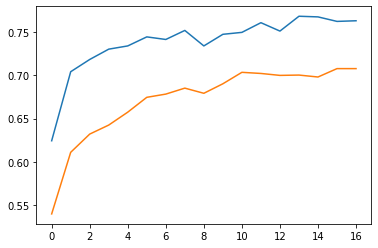

[output:4]

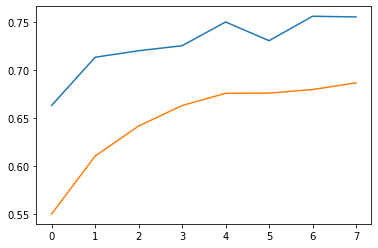

Out[0:23]: [<matplotlib.lines.Line2D at 0x7f1f50f44690>]

Out[5:23]: [<matplotlib.lines.Line2D at 0x7fe1e07b8710>]

[output:0]

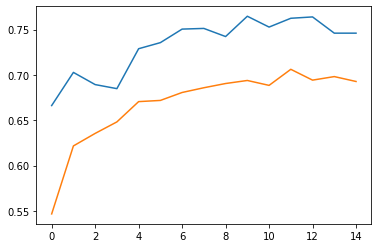

[output:5]

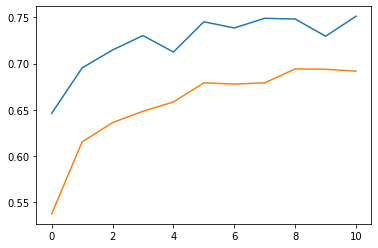

Out[2:23]: [<matplotlib.lines.Line2D at 0x7f19d4106390>]

Out[7:23]: [<matplotlib.lines.Line2D at 0x7f3f28349590>]

[output:2]

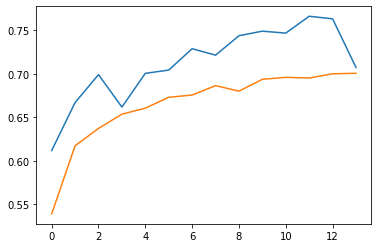

[output:7]

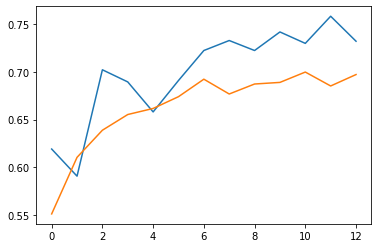

In [38]:
%%px
import matplotlib.pyplot as plt

plt.plot(history_1.history['val_accuracy'])
plt.plot(history_1.history['accuracy'])

In [39]:
client.shutdown(hub=True)

Controller stopped: {'exit_code': 0, 'pid': 84988, 'identifier': 'ipcontroller-1645891304-uh4w-84798'}
engine set stopped 1645891305: {'exit_code': 0, 'pid': 85082, 'identifier': 'ipengine-1645891304-uh4w-1645891305-84798'}


In [1]:
import tensorflow as tf

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model('model1') #path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.

with open('model1.tflite', 'wb') as f:
  f.write(tflite_model)

2022-02-26 16:35:55.034239: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-26 16:36:04.693314: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:363] Ignored output_format.
2022-02-26 16:36:04.693355: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:366] Ignored drop_control_dependency.
2022-02-26 16:36:04.693363: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:372] Ignored change_concat_input_ranges.
2022-02-26 16:36:04.694152: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: model1
2022-02-26 16:36:04.783062: I tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2022-02-26 16:36:04.783089: I tensorflow/cc/saved_mo